This program read the preprocessed data, in .npy format

use Convnet to train a model

This jupyter notebook is built with these previous contributors:
1. https://www.kaggle.com/devm2024/keras-model-for-beginners-0-210-on-lb-eda-r-d Keras Model for Beginners (0.210 on LB)+EDA+R&D by DeveshMaheshwari
2. https://www.kaggle.com/toregil/welcome-to-deep-learning-cnn-99 Welcome to deep learning (CNN 99%) by Peter Grenholm
3. https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/ Display Deep Learning Model Training History in Keras by Jason Brownlee
4. https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/ Evaluate the Performance Of Deep Learning Models in Keras by Jason Brownlee

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from os.path import join as opj
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

In [2]:
#import training data
X_train_rotate = np.load("X_train_rotate.npy")
target_train = np.load("target_train.npy")

In [3]:
print(X_train_rotate.shape)
print(target_train.shape)

(4812, 75, 75, 2)
(4812,)


for i in range(100):
    fig = plt.figure()
    ax = fig.add_subplot(1,2,1)
    ax.imshow(X_band_1[i])
    ax2= fig.add_subplot(1,2,2)
    ax2.imshow(X_band_2[i])
    plt.title(train['is_iceberg'][i])
    

# Convnet with Keras

### keras init

In [4]:
#Import Keras.
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation, BatchNormalization
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

Using TensorFlow backend.
/Users/yaqiongzhang/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [5]:
#define our model
def getModel():
    #Building the model
    gmodel=Sequential()
    #Conv Layer 1
    gmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(75, 75, 2)))
    gmodel.add(BatchNormalization())
    gmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu'))
    gmodel.add(BatchNormalization())
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    gmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu'))
    gmodel.add(BatchNormalization())
    gmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu'))
    gmodel.add(BatchNormalization())
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))
    
    #Flatten the data for upcoming dense layers
    gmodel.add(Flatten())

    #Dense Layers
    gmodel.add(Dense(512))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #Dense Layer 2
    gmodel.add(Dense(256))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #Sigmoid Layer
    gmodel.add(Dense(1))
    gmodel.add(Activation('sigmoid'))

    mypotim=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    gmodel.compile(loss='binary_crossentropy',
                  optimizer=mypotim,
                  metrics=['accuracy'])
    gmodel.summary()
    return gmodel


def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

file_path = "model_weights.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=5)

### Split data for validation

In [6]:
#import testing data
X_test = np.load("X_test.npy")
test_id = np.load("test_id.npy")

In [7]:
'''#https://machinelearningmastery.com/use-keras-deep-learning-models-scikit-learn-python/

# fix random seed for reproducibility

from sklearn.model_selection import StratifiedKFold
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

seed = 7
np.random.seed(seed)

gmodel = KerasClassifier(build_fn=getModel,
                         epochs = 10,
                         batch_size = 20,
                         verbose = 1,
                         )

# evaluate using 10-fold cross validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(gmodel, X_train_rotate, target_train, cv=kfold)

'''

'#https://machinelearningmastery.com/use-keras-deep-learning-models-scikit-learn-python/\n\n# fix random seed for reproducibility\n\nfrom sklearn.model_selection import StratifiedKFold\nfrom keras.wrappers.scikit_learn import KerasClassifier\nfrom sklearn.model_selection import StratifiedKFold\nfrom sklearn.model_selection import cross_val_score\n\nseed = 7\nnp.random.seed(seed)\n\ngmodel = KerasClassifier(build_fn=getModel,\n                         epochs = 10,\n                         batch_size = 20,\n                         verbose = 1,\n                         )\n\n# evaluate using 10-fold cross validation\nkfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)\nresults = cross_val_score(gmodel, X_train_rotate, target_train, cv=kfold)\n\n'

In [8]:
X_train_cv, X_valid, y_train_cv, y_valid = train_test_split(X_train_rotate, target_train, random_state=1, train_size=0.9)
#Without denoising, core features.

import os
gmodel=getModel()
history = gmodel.fit(X_train_cv, y_train_cv,
          batch_size=24,
          epochs=30,
          verbose=1,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 73, 73, 64)        1216      
_________________________________________________________________
batch_normalization_1 (Batch (None, 73, 73, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 71, 71, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        36928     
__________

In [9]:
'''from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10)
sub_list = []
i=0

import os
gmodel=getModel()
for train_index, test_index in kfold.split(X_train_rotate, target_train):
    gmodel.fit(X_train_rotate[train_index], target_train[train_index], 
               batch_size = 24,
               epochs = 1,
               verbose = 1,
               validation_data=(X_train_rotate[test_index], target_train[test_index]),
               callbacks=callbacks)
    
    #predict in the loop
    print('loaddata')
    gmodel.load_weights(filepath=file_path)
    print('predict')
    predicted_test=gmodel.predict_proba(X_test)
    print("predicted")
    sub_list [i] = predicted_test.reshape((predicted_test.shape[0]))
    i = i+1'''

'from sklearn.model_selection import StratifiedKFold\nkfold = StratifiedKFold(n_splits=10)\nsub_list = []\ni=0\n\nimport os\ngmodel=getModel()\nfor train_index, test_index in kfold.split(X_train_rotate, target_train):\n    gmodel.fit(X_train_rotate[train_index], target_train[train_index], \n               batch_size = 24,\n               epochs = 1,\n               verbose = 1,\n               validation_data=(X_train_rotate[test_index], target_train[test_index]),\n               callbacks=callbacks)\n    \n    #predict in the loop\n    print(\'loaddata\')\n    gmodel.load_weights(filepath=file_path)\n    print(\'predict\')\n    predicted_test=gmodel.predict_proba(X_test)\n    print("predicted")\n    sub_list [i] = predicted_test.reshape((predicted_test.shape[0]))\n    i = i+1'

### Training with Keras

In [11]:
gmodel.load_weights(filepath=file_path)
score = gmodel.evaluate(X_valid, y_valid, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

482/482 [==============================] - 14s 30ms/step
Test loss: 0.284251779303
Test accuracy: 0.881742738589


### plot training history

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


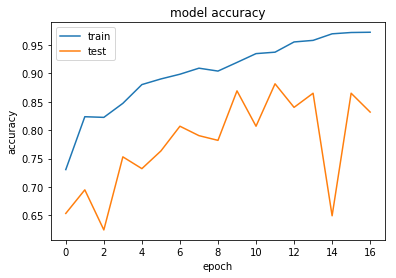

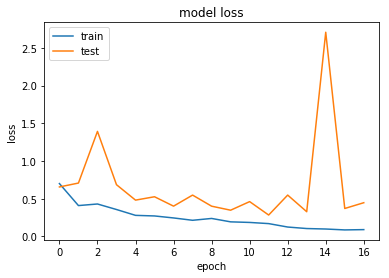

In [12]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# predict the test.json 

In [13]:
predicted_test=gmodel.predict_proba(X_test)

In [15]:
submission = pd.DataFrame()
submission['id']=test_id
submission['is_iceberg']=predicted_test.reshape((predicted_test.shape[0]))
submission.to_csv('sub.csv', index=False)